<a href="https://colab.research.google.com/github/drewamorbordelon/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS19_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

#Wrangle Data

In [ ]:
%matplotlib inline
from category_encoders import OrdinalEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

#Create Wrangle Function

In [ ]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # If `1`, waterpump is either `non functional` or `functional needs repair`
    # If `0`, waterpump is `functional`
    useless = ['quantity_group', 'payment_type', 'num_private', 
              'extraction_type_group', 'extraction_type_class', 'payment', 
              'source']

    train['needs_repair'] = (train['status_group'] != 'functional').astype(int)
    train.drop(['status_group', 'num_private', 
              'extraction_type_group', 'extraction_type_class', 'waterpoint_type_group', 
              'payment', 'source'], axis=1, inplace=True)

    return X


###Clean Train and Test DataFrames

In [ ]:
train = wrangle(train)
test = wrangle(test)

#Split Data

In [ ]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,management,management_group,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type,year_recorded,month_recorded,day_recorded,years,needs_repair
0,6000.0,Roman,1390.0,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,VWC,Roman,False,1999.0,gravity,vwc,user-group,annually,soft,good,enough,spring,groundwater,communal standpipe,2011,3,14,12,0
1,0.0,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,NaN,Other,NaN,True,2010.0,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,2013,3,6,3,0
2,25.0,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,vwc,user-group,per bucket,soft,good,enough,dam,surface,communal standpipe multiple,2013,2,25,4,0
3,0.0,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,VWC,NaN,True,1986.0,submersible,vwc,user-group,never pay,soft,good,dry,borehole,groundwater,communal standpipe multiple,2013,1,28,27,1
4,0.0,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,NaN,True,NaN,NaN,True,NaN,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,2011,7,13,2011,0


In [ ]:
# train_test_split
train, val = train_test_split(train, test_size=0.2, 
                              random_state=42)

In [ ]:
# target vector and feature matrix split
target = 'needs_repair'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5429713804713805


#Build Model

In [ ]:
#Randomized Forest Classifier
# Make Pipeline
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type', 'management',
                                      'management_group', 'payment_type',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source_type', 'source_class',
                                      'waterpoint...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_sam

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
                        
forest_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, random_state=42)
)
forest_model.fit(X_train, y_train);

In [ ]:
params = {'randomforestclassifier__n_estimators': range(50, 201, 50),
          'randomforestclassifier__max_depth': range(5, 26, 10)}

  

In [ ]:
#Randomized CV
rs = RandomizedSearchCV(
    forest_model,
    param_distributions = params,
    n_iter=10,
    verbose=5,  
)

#Check Metrics
###Accuracy Score

In [ ]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9958754208754209
Validation Accuracy: 0.8181818181818182


In [ ]:
forest_model.fit(X_train, y_train)
print('Validation Accuracy', forest_model.score(X_val, y_val))
y_pred = forest_model.predict(X_val)

Validation Accuracy 0.8258417508417508


In [ ]:
#Randomized CV
print('Training Accuracy:', forest_model.score(X_train, y_train))
print('Validation Accuracy:', forest_model.score(X_val, y_val))

Training Accuracy: 0.9999368686868687
Validation Accuracy: 0.8258417508417508


#Confusion Matrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report

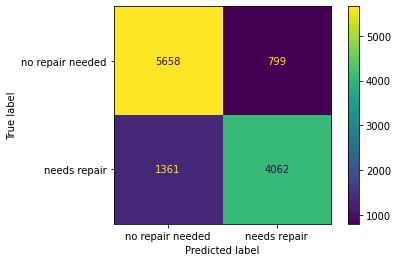

In [ ]:
plot_confusion_matrix(model, 
                      X_val, #Note using Validation data
                      y_val,
                      display_labels = ['no repair needed', 'needs repair'],
                      values_format='.0f')

#Precision and Recall

In [ ]:
print('Precision:', 4069 / (4069 + 1354))

Precision: 0.7503226996127604


In [ ]:
print('Recal:', 4069 / (4069 + 1354))

Recal: 0.7503226996127604


In [ ]:
print(classification_report(y_val, model.predict(X_val), target_names=['no repair', 'needs repair'])) # NOTE: Using validation data

              precision    recall  f1-score   support

   no repair       0.81      0.88      0.84      6457
needs repair       0.84      0.75      0.79      5423

    accuracy                           0.82     11880
   macro avg       0.82      0.81      0.81     11880
weighted avg       0.82      0.82      0.82     11880



# Quantifying Precision and Recall in Water Pump Repair

If the Tanzanian government didn't have a model, how many pumps would they repair vs. how much resources would be wasted?

Repair a pump => $100

In [ ]:
print(classification_report(y_val, model.predict(X_val), target_names=['no repair', 'needs repair'])) # NOTE: Using validation data

              precision    recall  f1-score   support

   no repair       0.81      0.88      0.84      6457
needs repair       0.84      0.75      0.79      5423

    accuracy                           0.82     11880
   macro avg       0.82      0.81      0.81     11880
weighted avg       0.82      0.82      0.82     11880



In [ ]:
threshold = .85
y_pred_mask = model.predict_proba(X_val)[:, -1] > threshold
X_sample = X_val.loc[y_pred_mask].sample(2000, random_state=42)
y_sample = y_val.loc[X_sample.index]

In [ ]:
print('Pumps Repaired:', y_sample.sum())

Pumps Repaired: 1945


In [ ]:
print('Wasted Funds:', (2000-1940)*100)

Wasted Funds: 6000


What if the government had our model?

In [ ]:
y_pred_mask = model.predict(X_val).astype(bool)
X_sample = X_val.loc[y_pred_mask].sample(2000, random_state=42)
y_sample = y_val.loc[X_sample.index]

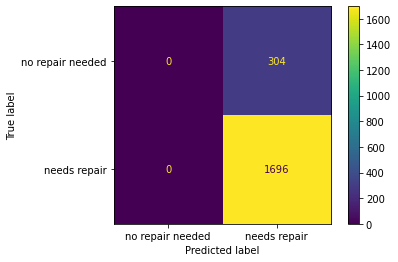

In [ ]:
plot_confusion_matrix(model,
                      X_sample, # NOTE: using validation data
                      y_sample,
                      display_labels = ['no repair needed', 'needs repair'],
                      values_format='.0f');

In [ ]:
print('Pumps Repaired:', 1666)
print('Wasted Funds:', 334*100)

Pumps Repaired: 1666
Wasted Funds: 33400
